# Section 06
## Exercise 06.1
The thermodynamic behaviour of a 50 spins 1D periodic Ising model will be studied estimating:
- the internal energy per spin: $\mathrm{u(T)} = \mathrm{U_N(T)}_{\mathrm{h}=0}/N$;
- the heat capacity per spin: $\mathrm{c(T)} = \mathrm{C_N(T)}_{\mathrm{h}=0}/N$;
- the magnetic susceptibility: $\Chi_\mathrm{N}(\mathrm{T})_{\mathrm{h}=0}$;
- the magnetization per spin: $\mathrm{m(T)} = \mathrm{M_N(T)}_{\mathrm{h}=0.02}/N$.

Here $\mathrm{h}$ is the external magnetic field and $N$ the number of spins. All the variables are in reduced units.

The estimation is carried out through the use of MCMC samplers.

In [1]:
import os
from typing import List, Any, Union, Dict

# using multiprocess instead of the standard library's multiprocessing as it works with jupyter notebooks
import multiprocess as mp
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 150, "ytick.minor.visible": True})

# Importing project specific variables and utilities, like the executables' paths
from global_utils import *
from ex06.vars import *
from ex06.data import *
from ex06.run import *
from ex06.plot import *


# Defining some constants
N_SPINS = 50
J = 1.0
H = 0.02

SAMPLERS = [Sampler.Metropolis, Sampler.Gibbs]
PROCESSES = max(os.cpu_count() - 1, 1)

USE_CACHED = True

In [2]:
def autocorr_2t(
    T: float, h: float, samplers: Union[Sampler, List[Sampler]] = SAMPLERS
) -> Dict[Sampler, Dict[str, int]]:
    dfs = read_autocorrelation(T, h, sampler=samplers)
    return {
        sampler: {var: df[(df < np.exp(-2))].iloc[0].name for var, col in zip(VARIABLES, df)}
        for sampler, df in dfs.items()
    }


def integrated_t(T: float, h: float, samplers: Union[Sampler, List[Sampler]] = SAMPLERS) -> Dict[Sampler, Dict[str, float]]:
    """Integrated autocorrelation time t_f as explained in https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr

    Args:
        T (float): Temperature.
        h (float): External magnetic field. Applied only in the estimation of m.
        samplers (Union[Sampler, List[Sampler]], optional): MCMC algorithms used. Defaults to SAMPLERS.

    Returns:
        Dict[Sampler, Dict[str, float]]: The integrated autocorrelation times per variable per sampler.
    """
    rho_ft = read_autocorrelation(T, h, sampler=samplers)
    # t_f(M) = 1 + 2*sum_{t=1}^M r_f(t), where r_f(t) is the autocorrelation computed for lag t.
    t_fM = {sampler: (1 + 2 * df.cumsum()) for sampler, df in rho_ft.items()}
    return {
        # retrieving, for each variable and sampler, the first entry for which M >= 5*t_f(M)
        sampler: {var: df[df.index >= 5 * df[var]].iloc[0][var] for var in df.columns}
        for sampler, df in t_fM.items()
    }


## Strategy
Two 1D Ising systems ($\mathrm{h}=0$ and $\mathrm{h}=0.02$) at 7 different values of $\mathrm{T}$ will be studied using the Metropolis-Hastings and Gibbs MCMC samplers. A single MC steps corresponds to trying to flip all the spins in the system, which is carried out in a random order by Metropolis and in a first to last fashion by Gibbs.

For each value of $\mathrm{T}$ the analysis is carried out in three steps:
- equilibration of the models;
- computation of the [integrated autocorrelation time](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr) $\tau_f$ for each system property and sampler;
- sampling and estimation of the thermodynamic variables.

The first step is necessary to bring the systems from a uniformly sampled state ($\mathrm{T} = \infty$) to a probable configuration for the given temperature.

The second will provide an estimation of the block size which will be used in the estimation procedure.

The third at last will provide the results.

### Equilibration of the model
Equilibration is performed using a tentative number of steps. Later analysis will show if it was enough.

During this phase the $\mathrm{h}=0$ system's energy ($\mathrm{H}$) and sum of spins ($\sum_i\mathrm{s_i}$) and the $\mathrm{h}=0.02$ system's ${(\sum_i\mathrm{s_i})}^2$ are recorded to both evaluate if the systems have reached equilibrium and to produce data needed for the computation of $\tau_f$.
To evaluate if the systems have reached equilibrium we will check whether the series of data have stabilized.

The equilibration is carried out for two different Ising system to avoid as much as possible to end up in a metastable configuration.


In [3]:
# temperatures which will be studied.
Ts = np.linspace(0.5, 2.0, 7)


In [4]:
# Computations is done in parallel on different temperatures using multiprocess' "Pool".
# Routines (functions of T) produced by the "run_*" utilities are mapped on the array "Ts"
with mp.Pool(processes=PROCESSES) as pool:
    results = list(
        pool.imap_unordered(
            # This utility returns a function of T; read its documentation for further insights
            run_equilibration(
                J,
                H,
                N_SPINS,
                SAMPLERS,
                # number of steps to perform and register
                n_register=50_000,
                n_steps=50_000,
                # saving the state reached
                save_spins=True,
                use_cached=USE_CACHED
            ),
            Ts,
        )
    )


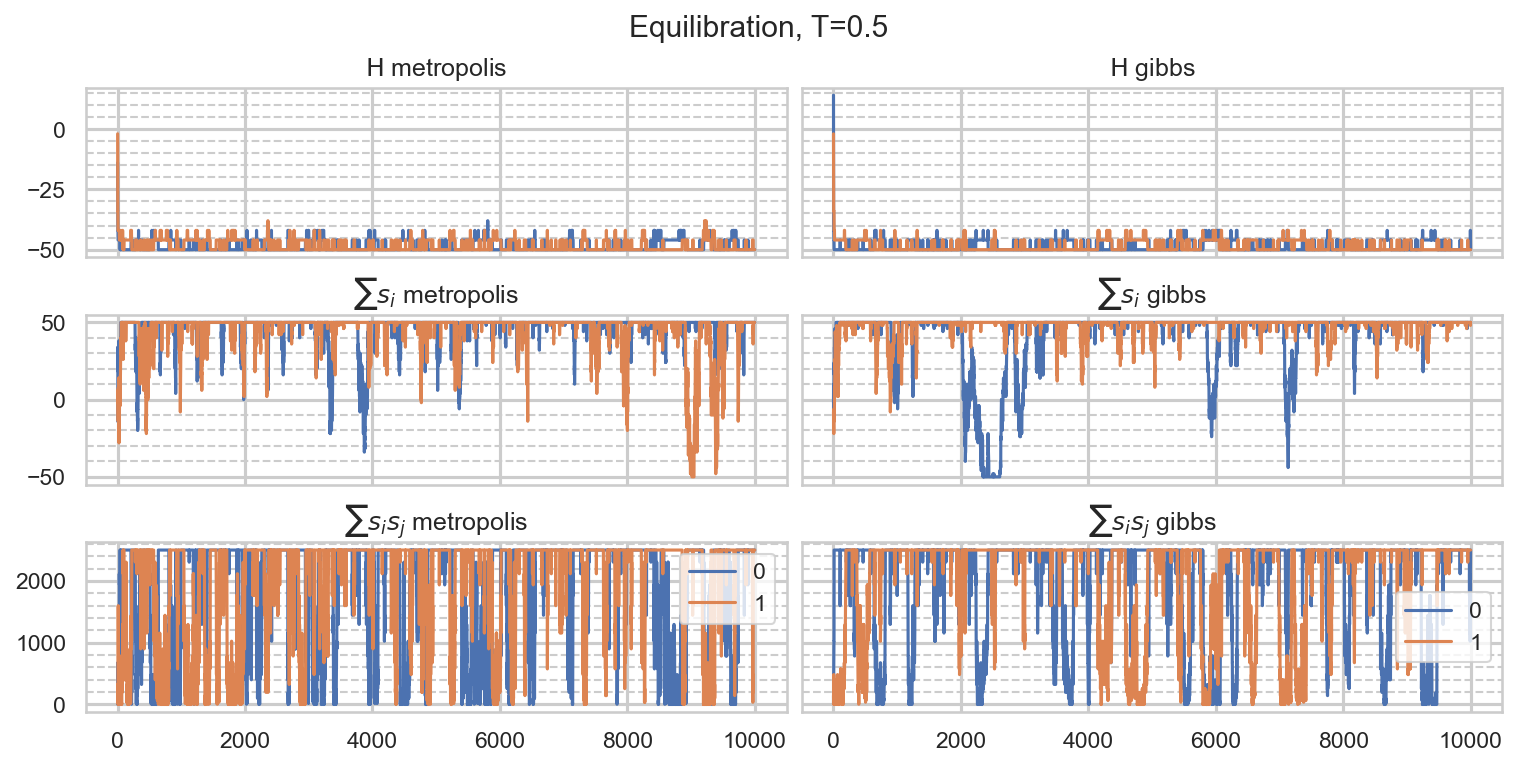

In [5]:
# looking at the results
show_equilibrations(T=0.5, h=H, samplers=SAMPLERS, take=10_000);

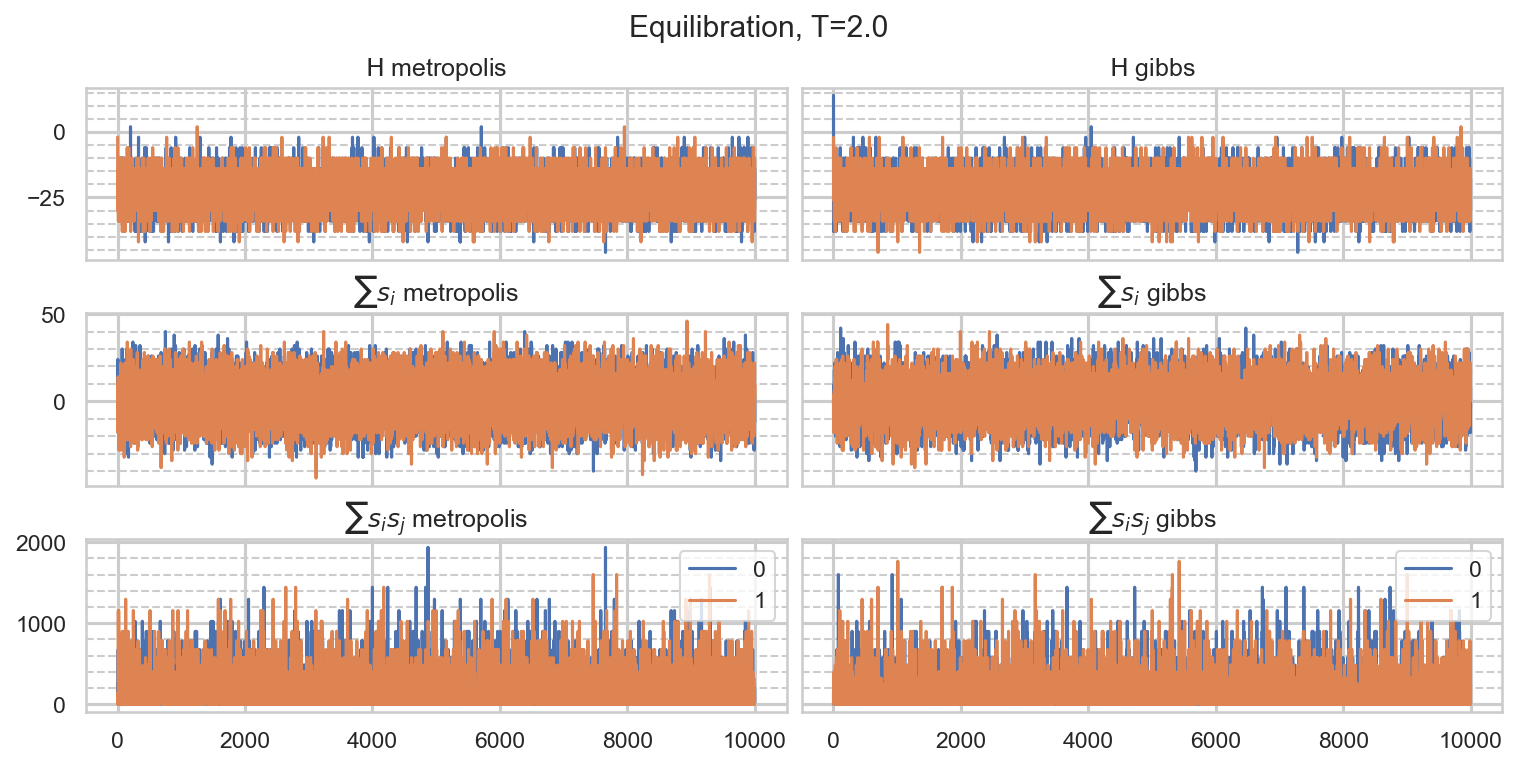

In [6]:
show_equilibrations(T=2.0, h=H, samplers=SAMPLERS, take=10_000);

The plots above, showing the equilibration for $\mathrm{T}=0.5$ and $\mathrm{T}=2.0$, implies that the chosen number of steps is more than enough for the two extremes in temperature. The same is true also for the other values (it is not plotted as it is not necessary).

### Autocorrelation time
The autocorrelation time is estimated from the expression:
$$
\hat{\tau}_f(M) = 1 + 2\sum_{t=1}^M \hat{a}_f(t)
$$
where $\hat{a}_f(t)$ is the autocorrelation function computed at lag $t$ for the variable $f$.

The time is then chosen picking the minimum $M$ such that $M \ge 5\tau_f(M)$. The autocorrelation function is computed on a subset of the previously acquired data using the $\mathrm{statsmodels}$ library's $\mathrm{acf}$ function, which is implemented using the FFT algorithm.

The Ising systems' properties ($\mathrm{H}$, $\sum \mathrm{s_i}$ and $(\sum \mathrm{s_i})^2$) can be used to evaluate autocorrelation as the thermodynamical variables of interest are proportional to them.

In [7]:
with mp.Pool(processes=PROCESSES) as pool:
    list(
        # run_autocorr returns a function in T performing the required computations and passes it to the process pool.
        # n_lags determines the subset of data on which the autocorr. function is computed.
        # Setting fft to False makes the routine use the program that I wrote, which is slower (as it relies on the definition of a_f(t) instead of FFT)
        pool.imap_unordered(run_autocorr(H, SAMPLERS, n_lags=100_000, skip_steps=0, fft=True, use_cached=USE_CACHED), Ts)
    )


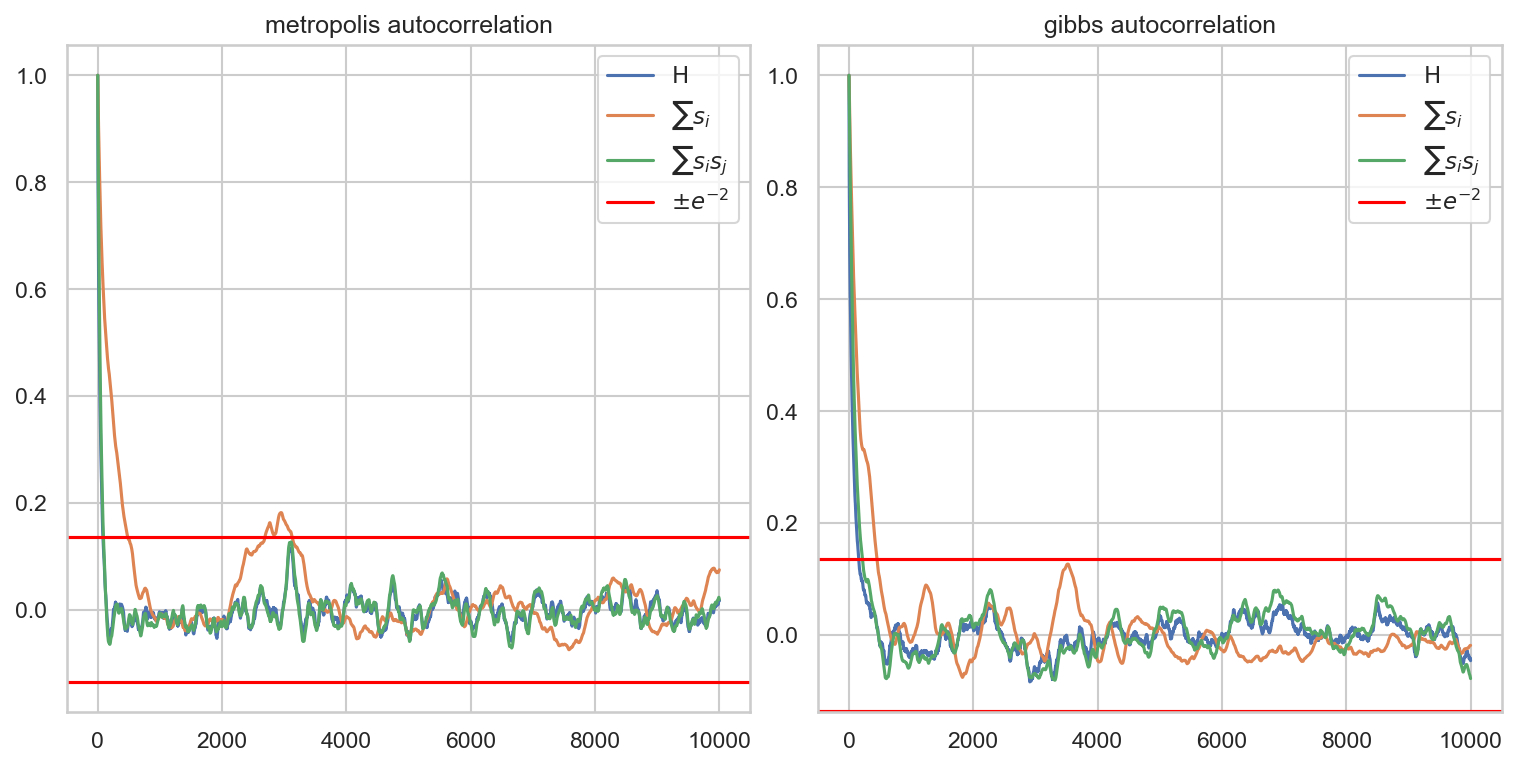

In [8]:
# Displaying some autocorrelation functions
show_autocorrelations(0.5, H, SAMPLERS, lags=10_000);

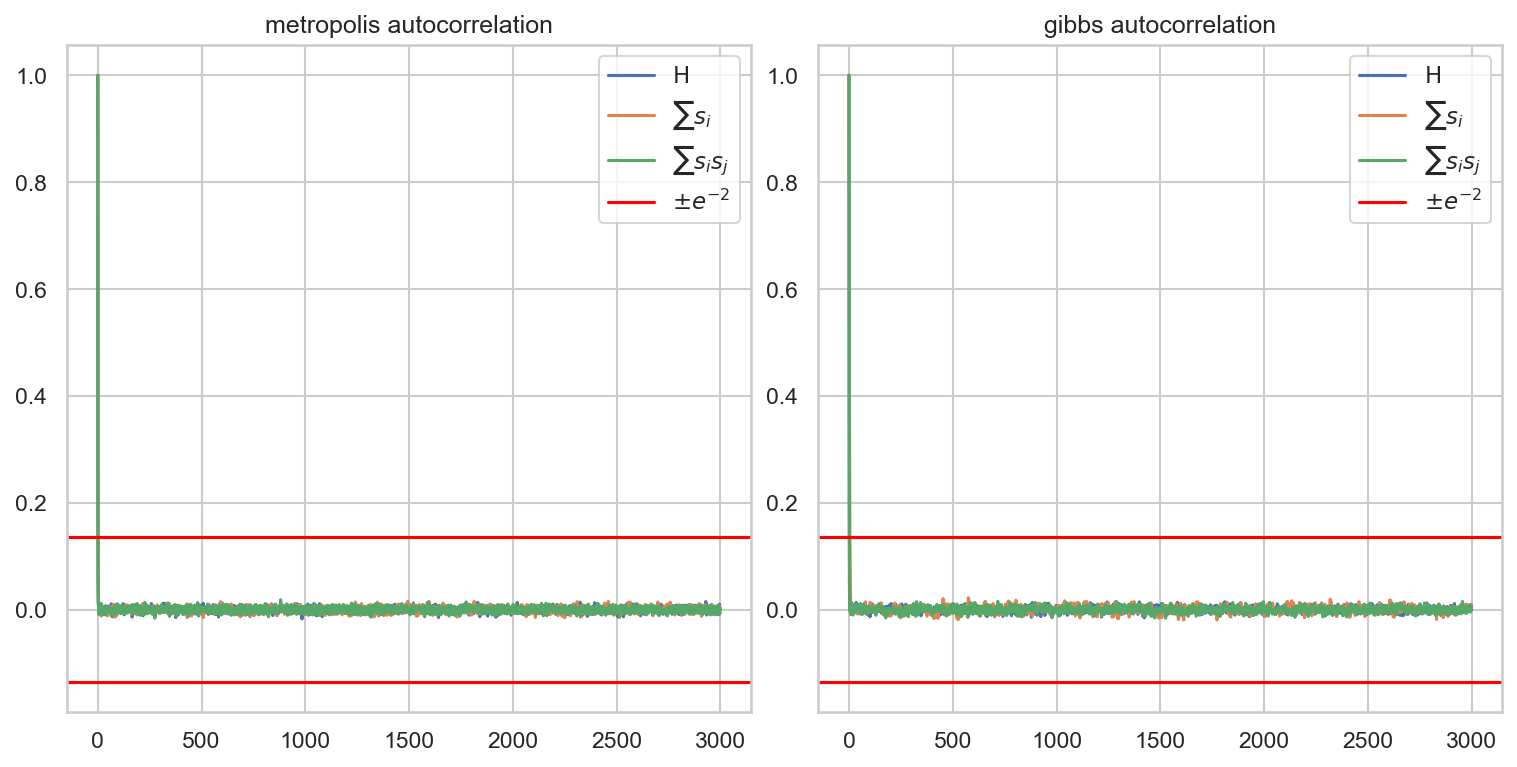

In [9]:
show_autocorrelations(2.0, H, SAMPLERS, lags=3_000);

As could be seen in the equilibration process, lower temperatures are associated to higher correlation times.

In [10]:
# Producing the autocorrelation time tables. Each column represents one of the system properties.
corr_dfs = {sampler: pd.DataFrame.from_dict(
    {
        "columns": RENAMES.keys(),
        "index": Ts,
        "data": [integrated_t(T, H, sampler)[sampler] for T in Ts],
        "index_names": "T",
        "column_names": ["Var"],
    },
    orient="tight",
) for sampler in SAMPLERS}

# Pretty printing
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print("Integrated autocorrelation times for the Metropolis sampler:")
    display(corr_dfs[Sampler.Metropolis])
    print("Integrated autocorrelation times for the Gibbs sampler:")
    display(corr_dfs[Sampler.Gibbs])


Integrated autocorrelation times for the Metropolis sampler:


Var,H,Sum_s,Sum_s2
T,,,
0.50,69.19,390.40,78.48
0.75,12.75,47.87,21.85
1.00,6.07,17.77,8.76
1.25,4.62,8.52,5.11
1.50,4.05,5.74,4.12
1.75,3.72,4.74,3.49
2.00,3.54,3.75,3.23


Integrated autocorrelation times for the Gibbs sampler:


Var,H,Sum_s,Sum_s2
T,,,
0.50,138.24,401.20,183.78
0.75,18.73,74.26,54.95
1.00,7.16,28.67,15.64
1.25,4.86,14.97,8.22
1.50,4.23,9.87,6.00
1.75,3.95,7.27,4.68
2.00,3.69,6.13,4.03


From the tables it can be seen that an autocorrelation time of 500 could be used as reference for all measures's block size: as autocorrelation reduces over time employing a greater than needed size should do no harm.

### Estimations

The thermodynamical variables are estimated using the expressions:
- $\mathrm{u(T)} = \langle \mathrm{H} \rangle_{\mathrm{h}=0}/N$;
- $\mathrm{c(T)} = \beta^2\langle\langle \mathrm{H} \rangle\rangle_{\mathrm{h}=0}/N$;
- $\Chi_\mathrm{N}(\mathrm{T}) = \beta\langle(\sum \mathrm{s_i})^2\rangle_{\mathrm{h}=0}$;
- $\mathrm{m(T)} = \langle \sum \mathrm{s_i} \rangle_{\mathrm{h}=0.02}/N$.

A C++ executable simulates the Ising model and estimates those quantities starting from the states reached during equilibration. 
 

In [11]:
# global t_f
t_glob = 500

with mp.Pool(processes=PROCESSES) as pool:
    list(
        pool.imap_unordered(
            run_measures(
                J,
                H,
                N_SPINS,
                SAMPLERS,
                # performing more than 1000*t_f steps as suggested by the emcee documentation
                # (taken from Sokal).
                n_steps=2*t_glob*2000,
                # using a block_size of 2*t_f as suggested by the lecture notes
                block_size=2*t_glob,
                prime_line=2,
                use_cached=USE_CACHED
            ),
            Ts,
        )
    )


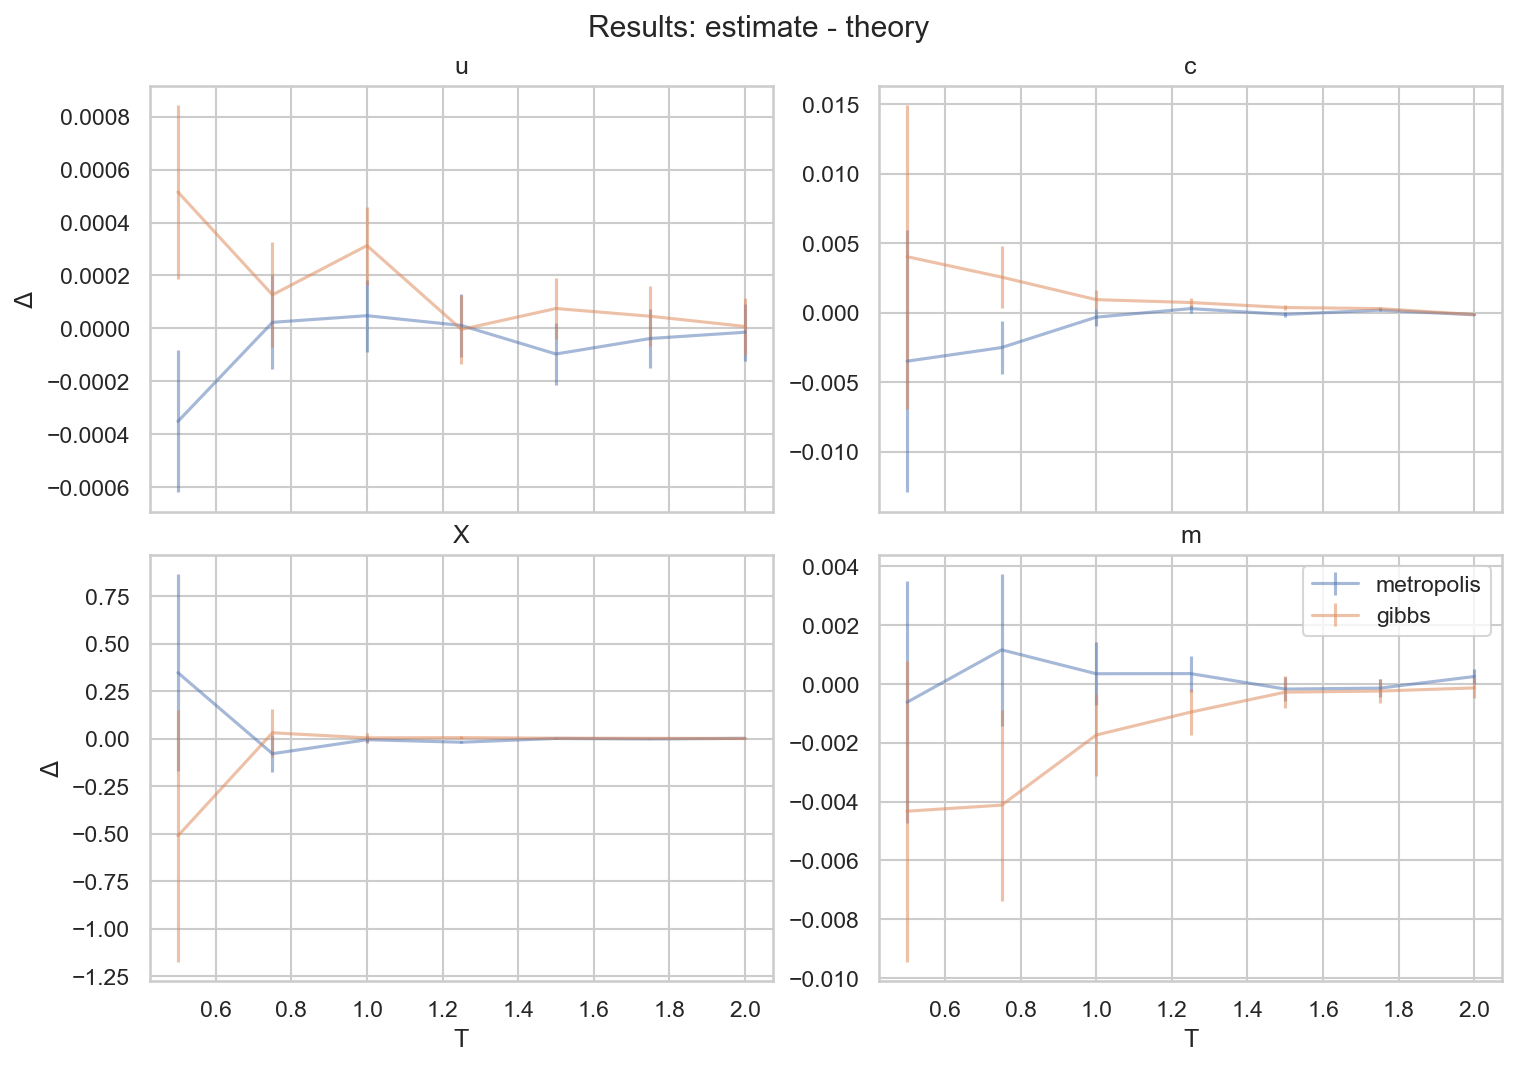

In [12]:
_ = show_results(J, Ts, H, N_SPINS, SAMPLERS)


Results show some degree of accordance between theory and measurements, though the statistical error seems underestimated.

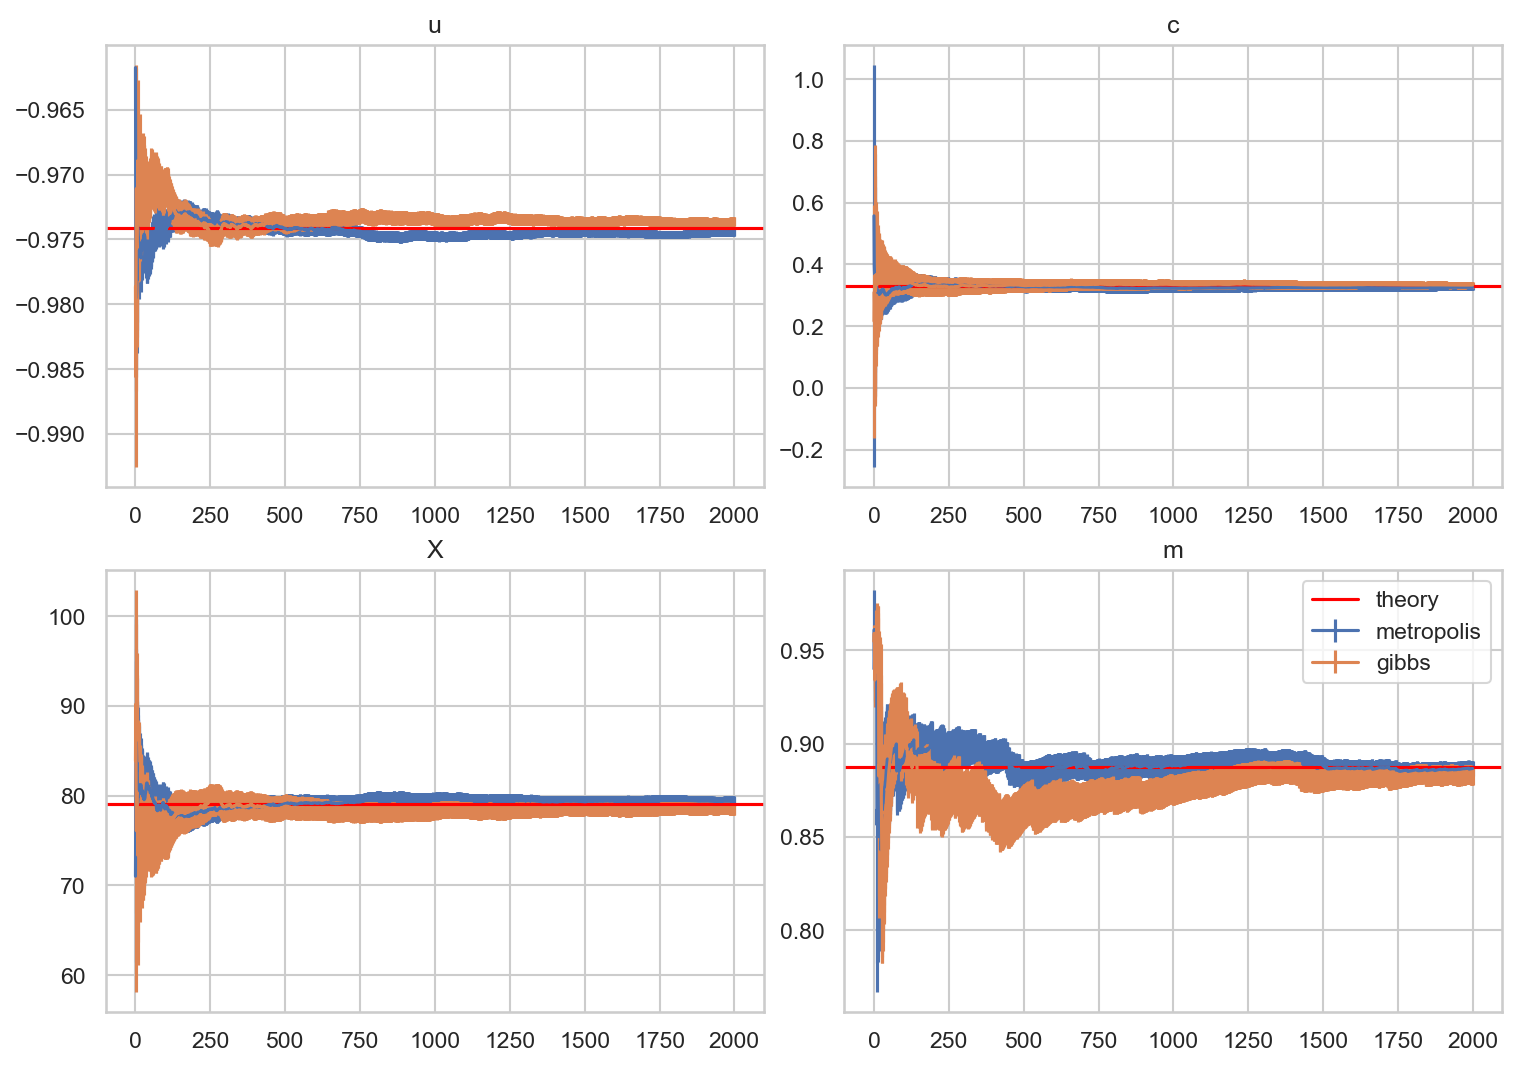

In [13]:
# An exampmle of estimation
show_measures(J, 0.5, H, N_SPINS, SAMPLERS);